### Analysis of the Dataset Generation Script

#### Core Functionality

The script's effectiveness comes from its multi-layered approach to simulating realistic user behavior:

*   **Grounded in Reality:** It uses a real-world list of academic conferences from the `CORE_2023.csv` file as a base, ensuring that the items being reviewed are authentic.

*   **User Simulation:** It creates two distinct user archetypes to mimic real-world engagement patterns:
    *   **Regular Users (1000):** A large group with moderate review activity (5-15 reviews each).
    *   **Influencers (50):** A small, highly active group with a large number of reviews (50-100 reviews each), who are crucial for establishing strong data connections in the model.

*   **Persona-Driven Content:** Each simulated user is assigned a **Persona** (e.g., "PhD Student," "Senior Professor"). This is a key feature that dictates the *content* of their reviews. For example, a "PhD Student" persona is more likely to generate reviews that mention the cost of attendance.

*   **Nuanced Review Generation Engine:** The script avoids simple, repetitive templates. It constructs human-like reviews by intelligently combining phrases from a predefined library based on three factors:
    1.  The **star rating** (1-5).
    2.  The user's assigned **persona**.
    3.  **Random structural variations** (e.g., a 4-star review might be mostly positive but include a minor, persona-relevant complaint).

#### Workflow Summary

The script executes the following steps in sequence:
1.  **Load Conferences:** Reads the `CORE_2023.csv` file and creates a unique list of conference keys in the format `"acronym - title"`.
2.  **Simulate Users:** Generates user IDs for both regular and influencer groups and assigns a random persona to each.
3.  **Generate Reviews:** Iterates through each user, generating a random number of reviews. For each review, it generates a rating, a detailed text review, and a random timestamp.
4.  **Save Dataset:** Compiles all the generated data into a pandas DataFrame and saves it as a single, clean CSV file named `conference_reviews_dataset.csv`.

In [ ]:
import pandas as pd
import random
from datetime import datetime, timedelta
import os

# --- 1. SCRIPT CONFIGURATION ---
# These parameters control the size and characteristics of the generated dataset.

# Input file containing the list of real conferences.
# Expected format: CSV with no header, conference title in the 2nd column, acronym in the 3rd.
CORE_FILE_PATH = 'CORE_2023.csv'

# Output file where the final dataset will be saved.
OUTPUT_FILE_PATH = 'conference_reviews_dataset.csv'

# Number of standard users to simulate.
NUM_REGULAR_USERS = 1000
# Number of highly active users (influencers) to simulate.
NUM_INFLUENCERS = 50

# The range of reviews a regular user will write (e.g., between 5 and 15).
REVIEWS_PER_REGULAR_USER = (5, 15)
# The range of reviews an influencer will write (much higher than regular users).
REVIEWS_PER_INFLUENCER = (50, 100)


# --- 2. REVIEW GENERATION ENGINE ---
# This section defines the building blocks for creating realistic text reviews.

# A comprehensive library of phrases categorized by sentiment (positive, negative, neutral)
# and aspect (papers, networking, etc.). This allows for modular review construction.
PHRASES = {
    "positive": {
        "papers": ["The technical program was exceptionally strong.", "Groundbreaking research was presented throughout.", "The quality of accepted papers was consistently high."],
        "keynotes": ["The keynote speakers were world-class and truly inspiring.", "A thought-provoking and memorable keynote lineup."],
        "networking": ["Exceptional networking opportunities with leading researchers.", "The social events were vibrant and well-attended.", "I made several valuable connections."],
        "organization": ["Impeccably organized from start to finish.", "The organizing committee did a phenomenal job.", "A beautiful and well-equipped venue."],
        "location": ["The host city was a wonderful choice, with plenty to see and do.", "Great location with easy access to transport."]
    },
    "negative": {
        "papers": ["The technical depth of the papers was disappointing this year.", "Felt like many presentations were incremental at best.", "The program was too broad, lacking focus."],
        "cost": ["The registration fee was unjustifiably high.", "Poor value for money, considering the additional costs.", "The cost is becoming a significant barrier for students."],
        "organization": ["The organization felt chaotic and last-minute.", "Poor communication from the organizers.", "The Wi-Fi was unreliable, which is unacceptable."],
        "networking": ["Networking felt cliquey and difficult for newcomers.", "The social events were poorly planned.", "The poster session was disorganized and cramped."],
        "location": ["The location was inconvenient and difficult to get to.", "A boring host city with very few amenities nearby."]
    },
    "neutral": {
        "observation": ["The conference seemed smaller than in previous years.", "There was a noticeable shift in focus towards industry applications.", "The hybrid format had both pros and cons."],
        "conditional": ["It was a good conference, although...", "While I enjoyed the keynotes, ...", "Overall a positive experience, but..."]
    }
}

# Defines different user personas. Each persona has specific aspects they are likely
# to focus on when giving positive or negative feedback. For example, a 'phd_student'
# is more likely to complain about 'cost'.
PERSONAS = {
    "phd_student": {"pos_focus": ["networking", "papers"], "neg_focus": ["cost", "networking"], "neu_focus": ["observation"]},
    "early_career_researcher": {"pos_focus": ["papers", "networking"], "neg_focus": ["organization", "cost"], "neu_focus": ["observation"]},
    "senior_professor": {"pos_focus": ["papers", "keynotes"], "neg_focus": ["papers", "organization"], "neu_focus": ["observation"]},
    "industry_expert": {"pos_focus": ["networking", "keynotes"], "neg_focus": ["organization", "papers"], "neu_focus": ["observation"]},
}


def generate_diverse_review(rating: int, persona_key: str) -> str:
    """
    Constructs a realistic, multi-part text review based on a star rating and a user persona.

    This function intelligently combines phrases from the PHRASES library to create reviews
    that are more nuanced than simple templates. For example, a 4-star review might be
    mostly positive but include a minor complaint relevant to the user's persona.

    Args:
        rating (int): The star rating (1-5) for the review.
        persona_key (str): The key for the user's persona (e.g., 'phd_student').

    Returns:
        str: A fully constructed, human-like review text.
    """
    persona = PERSONAS[persona_key]
    review_parts = []

    # Logic for a 5-star (purely positive) review
    if rating == 5:
        num_parts = random.randint(2, 3)
        aspects = random.sample(list(PHRASES["positive"].keys()), num_parts)
        # Ensure at least one part is relevant to the persona's positive focus
        if not any(p in aspects for p in persona["pos_focus"]):
            aspects[0] = random.choice(persona["pos_focus"])
        for aspect in aspects:
            review_parts.append(random.choice(PHRASES["positive"][aspect]))

    # Logic for a 4-star (mostly positive with a minor negative point) review
    elif rating == 4:
        review_parts.append(random.choice(PHRASES["neutral"]["conditional"]))
        pos_aspects = random.sample(list(PHRASES["positive"].keys()), 2)
        review_parts.extend([random.choice(PHRASES["positive"][a]) for a in pos_aspects])
        neg_aspect = random.choice(persona["neg_focus"]) # Negative point is persona-driven
        review_parts.append(random.choice(PHRASES["negative"][neg_aspect]))
        random.shuffle(review_parts[1:]) # Shuffle to vary sentence order

    # Logic for a 3-star (mixed/neutral) review
    elif rating == 3:
        pos_aspect = random.choice(persona["pos_focus"])
        neg_aspect = random.choice(persona["neg_focus"])
        review_parts.append(random.choice(PHRASES["positive"][pos_aspect]))
        review_parts.append(random.choice(PHRASES["negative"][neg_aspect]))
        random.shuffle(review_parts)

    # Logic for a 2-star (mostly negative with a minor positive point) review
    elif rating == 2:
        review_parts.append(random.choice(PHRASES["neutral"]["conditional"]))
        neg_aspects = random.sample(list(PHRASES["negative"].keys()), 2)
        review_parts.extend([random.choice(PHRASES["negative"][a]) for a in neg_aspects])
        pos_aspect = random.choice(persona["pos_focus"]) # Positive point is persona-driven
        review_parts.append(random.choice(PHRASES["positive"][pos_aspect]))
        random.shuffle(review_parts[1:])

    # Logic for a 1-star (purely negative) review
    elif rating == 1:
        num_parts = random.randint(2, 3)
        aspects = random.sample(list(PHRASES["negative"].keys()), num_parts)
        # Ensure at least one part is relevant to the persona's negative focus
        if not any(p in aspects for p in persona["neg_focus"]):
            aspects[0] = random.choice(persona["neg_focus"])
        for aspect in aspects:
            review_parts.append(random.choice(PHRASES["negative"][aspect]))

    # Join the parts into a single string and perform minor cleanup.
    return ' '.join(review_parts).replace("... ", ". ").replace("..", ".")


def generate_random_timestamp() -> int:
    """
    Generates a random Unix timestamp within the last 3 years.

    Returns:
        int: A Unix timestamp representing a random point in time.
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3 * 365)
    random_date = start_date + (end_date - start_date) * random.random()
    return int(random_date.timestamp())


def load_conferences(file_path: str) -> list | None:
    """
    Loads conference data from the CORE CSV file.

    It reads the file, extracts the acronym and title for each conference,
    and combines them into a unique key (e.g., "ICLR - International Conference...").
    This key format is used throughout the recommendation system.

    Args:
        file_path (str): The path to the CORE CSV file.

    Returns:
        list | None: A list of unique conference keys, or None if the file is not found.
    """
    try:
        df = pd.read_csv(file_path, header=None, on_bad_lines='skip', encoding='utf-8')
        conferences = []
        for _, row in df.iterrows():
            try:
                title = str(row[1]).strip()
                acronym = str(row[2]).strip()
                # Ensure both acronym and title are valid before creating a key
                if acronym and acronym != 'nan' and title:
                    key = f"{acronym} - {title}"
                    conferences.append(key)
            except (IndexError, TypeError):
                continue # Skip malformed rows
        return list(set(conferences)) # Return only unique conference keys
    except FileNotFoundError:
        print(f"❌ Error: The file '{file_path}' was not found.")
        return None


def main():
    """
    Main execution function for the script.

    This function orchestrates the entire dataset generation process:
    1. Checks if a dataset already exists to prevent overwriting.
    2. Loads the base conference data.
    3. Simulates users and assigns personas.
    4. Loops through users to generate reviews.
    5. Saves the final, complete dataset to a CSV file.
    """
    print("="*50)
    print("🚀 Starting Synthetic Dataset Generation...")
    print("="*50)

    # --- Safety Check ---
    # Prevent accidentally overwriting a previously generated dataset.
    if os.path.exists(OUTPUT_FILE_PATH):
        print(f"✅ Dataset file '{OUTPUT_FILE_PATH}' already exists.")
        print("   Generation skipped to avoid overwriting.")
        return

    # --- Step 1: Load Conferences ---
    print(f"📂 Loading conferences from '{CORE_FILE_PATH}'...")
    conferences = load_conferences(CORE_FILE_PATH)
    if not conferences:
        print("❌ Could not load conferences. Aborting generation.")
        return
    print(f"   - Loaded {len(conferences)} unique conferences.")

    # --- Step 2: Simulate Users ---
    print(f"👥 Simulating {NUM_REGULAR_USERS} regular users and {NUM_INFLUENCERS} influencers...")
    total_users = NUM_REGULAR_USERS + NUM_INFLUENCERS
    user_ids = [f"user_{i}" for i in range(total_users)]
    influencer_ids = set(random.sample(user_ids, NUM_INFLUENCERS))
    regular_user_ids = [uid for uid in user_ids if uid not in influencer_ids]
    user_personas = {uid: random.choice(list(PERSONAS.keys())) for uid in user_ids}
    print("   - User simulation complete.")

    # --- Step 3: Generate Reviews ---
    dataset = []
    
    print("✍️  Generating reviews for influencers...")
    for user_id in influencer_ids:
        num_reviews = random.randint(*REVIEWS_PER_INFLUENCER)
        reviewed_confs = random.sample(conferences, min(num_reviews, len(conferences)))
        for conf_key in reviewed_confs:
            # Influencers are slightly more likely to give higher ratings
            rating = random.choices([1, 2, 3, 4, 5], weights=[5, 10, 25, 35, 25], k=1)[0]
            review = generate_diverse_review(rating, user_personas[user_id])
            timestamp = generate_random_timestamp()
            dataset.append([user_id, conf_key, rating, review, timestamp])

    print("✍️  Generating reviews for regular users...")
    for user_id in regular_user_ids:
        num_reviews = random.randint(*REVIEWS_PER_REGULAR_USER)
        reviewed_confs = random.sample(conferences, min(num_reviews, len(conferences)))
        for conf_key in reviewed_confs:
            # Regular users have a more standard rating distribution
            rating = random.choices([1, 2, 3, 4, 5], weights=[10, 15, 30, 25, 20], k=1)[0]
            review = generate_diverse_review(rating, user_personas[user_id])
            timestamp = generate_random_timestamp()
            dataset.append([user_id, conf_key, rating, review, timestamp])

    print(f"   - Generated a total of {len(dataset)} reviews.")

    # --- Step 4: Save Dataset ---
    print(f"💾 Saving final dataset to '{OUTPUT_FILE_PATH}'...")
    df = pd.DataFrame(dataset, columns=['user_id', 'conference_key', 'rating', 'review', 'timestamp'])
    df.to_csv(OUTPUT_FILE_PATH, index=False)

    print("\n" + "="*50)
    print("🎉 SUCCESS: Dataset generation complete!")
    print("="*50)


if __name__ == "__main__":
    main()

Dataset file 'conference_reviews_dataset.csv' already exists.
Generation skipped to avoid overwriting.


          DATASET ANALYSIS REPORT

[--- 1. Sample Data ---]
Here are the first 5 rows of your dataset:
| id                                   | conference_key                       | user_id                              | review                                                                                                                                                                                                          |   rating | createdAt                                                      | updatedAt                                                      |
|:-------------------------------------|:-------------------------------------|:-------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------:|:---------------------------------------------------------------|:----------------------

C:\Users\Le Loi\AppData\Local\Temp\ipykernel_9812\2496453067.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=rating_df['Rating'], y=rating_df['Count'], palette="viridis")


Saved 'rating_distribution.png'
Saved 'user_activity_distribution_counts.png'

Analysis complete.


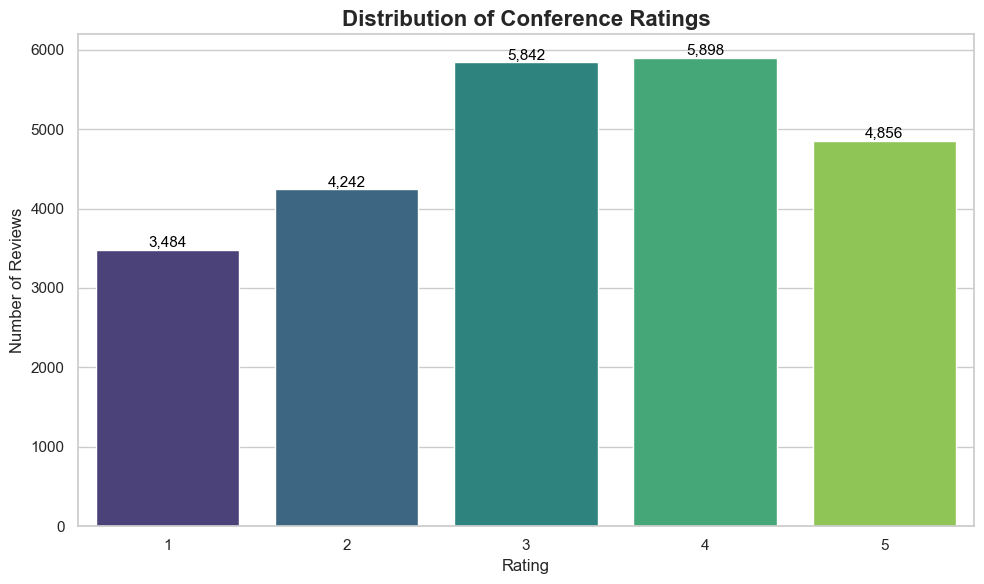

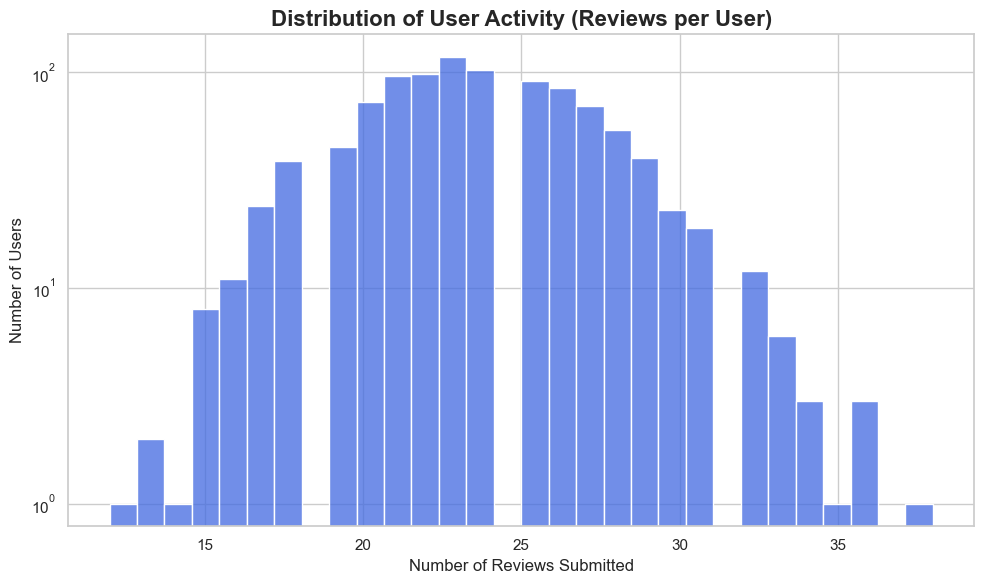

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
DATASET_FILE_PATH = 'conference_feedbacks_export.csv'

def analyze_dataset(file_path):
    """
    Loads the dataset and performs a comprehensive statistical analysis.
    """
    # --- 1. Load Data ---
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The dataset file '{file_path}' was not found.")
        print("Please run the generation script first.")
        return

    # --- RENAME COLUMNS TO MATCH EXISTING CODE LOGIC ---
    # Điều chỉnh tên cột để phù hợp với logic code hiện có
    df = df.rename(columns={
        'creatorId': 'user_id',
        'conferenceId': 'conference_key',
        'star': 'rating',
        'description': 'review'
    })

    print("="*50)
    print("          DATASET ANALYSIS REPORT")
    print("="*50)

    # --- 2. Display Sample Data ---
    print("\n[--- 1. Sample Data ---]")
    print("Here are the first 5 rows of your dataset:")
    print(df.head().to_markdown(index=False))
    
    # --- 3. Overall Statistics ---
    print("\n[--- 2. Overall Statistics ---]")
    total_reviews = len(df)
    num_users = df['user_id'].nunique()
    num_conferences = df['conference_key'].nunique()
    
    stats_data = {
        "Metric": ["Total Reviews", "Unique Users", "Unique Conferences"],
        "Value": [f"{total_reviews:,}", f"{num_users:,}", f"{num_conferences:,}"]
    }
    stats_df = pd.DataFrame(stats_data)
    print(stats_df.to_markdown(index=False))

    # --- 4. User Activity Analysis ---
    print("\n[--- 3. User Activity Analysis ---]")
    user_activity = df['user_id'].value_counts()
    
    user_activity_stats = {
        "Metric": [
            "Reviews per User (Average)",
            "Reviews per User (Median)",
            "Most Active User (Reviews)",
            "Least Active User (Reviews)"
        ],
        "Value": [
            f"{user_activity.mean():.2f}",
            f"{user_activity.median():.0f}",
            f"{user_activity.max()}",
            f"{user_activity.min()}"
        ]
    }
    user_activity_df = pd.DataFrame(user_activity_stats)
    print(user_activity_df.to_markdown(index=False))
    
    # --- 5. Rating Distribution ---
    print("\n[--- 4. Rating Distribution ---]")
    rating_dist = df['rating'].value_counts().sort_index()
    rating_dist_percent = df['rating'].value_counts(normalize=True).sort_index() * 100
    
    rating_df = pd.DataFrame({
        'Rating': rating_dist.index,
        'Count': rating_dist.values,
        'Percentage (%)': rating_dist_percent.values.round(2)
    })
    print(rating_df.to_markdown(index=False))
    
    # --- 6. Review Text Analysis ---
    print("\n[--- 5. Review Text Analysis ---]")
    # Đảm bảo cột 'review' tồn tại và là kiểu string
    df['review_length'] = df['review'].astype(str).str.split().str.len()
    
    review_stats = {
        "Metric": [
            "Review Length in Words (Average)",
            "Review Length in Words (Median)",
            "Longest Review (Words)",
            "Shortest Review (Words)"
        ],
        "Value": [
            f"{df['review_length'].mean():.2f}",
            f"{df['review_length'].median():.0f}",
            f"{df['review_length'].max()}",
            f"{df['review_length'].min()}"
        ]
    }
    review_stats_df = pd.DataFrame(review_stats)
    print(review_stats_df.to_markdown(index=False))
    
    # --- 7. Visualizations ---
    print("\n[--- 6. Generating Visualizations ---]")
    
    # Set plot style
    sns.set_theme(style="whitegrid")
    
    # Figure 1: Rating Distribution
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=rating_df['Rating'], y=rating_df['Count'], palette="viridis")
    ax.set_title('Distribution of Conference Ratings', fontsize=16, fontweight='bold')
    ax.set_xlabel('Rating', fontsize=12)
    ax.set_ylabel('Number of Reviews', fontsize=12)
    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.tight_layout()
    plt.savefig('rating_distribution.png')
    print("Saved 'rating_distribution.png'")

    # --- Figure 2: User Activity Distribution (Histogram) ---
    plt.figure(figsize=(10, 6))

    # CHANGE: Remove kde=True and you can add stat='count' for clarity
    ax = sns.histplot(user_activity, bins=30, stat='count', kde=False, color='royalblue') 

    ax.set_title('Distribution of User Activity (Reviews per User)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Reviews Submitted', fontsize=12)
    ax.set_ylabel('Number of Users', fontsize=12) # This label is now correct!
    ax.set_yscale('log') # The log scale will now show 1, 10, 100, etc.
    plt.tight_layout()
    plt.savefig('user_activity_distribution_counts.png')
    print("Saved 'user_activity_distribution_counts.png'")
    
    print("\nAnalysis complete.")
    print("="*50)


if __name__ == "__main__":
    analyze_dataset(DATASET_FILE_PATH)